In [ ]:
# Checking GPU availability

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Installing the Hugging Face PyTorch Interface for Bert

!pip install -q transformers

     |████████████████████████████████| 2.8 MB 11.5 MB/s 
     |████████████████████████████████| 636 kB 46.3 MB/s 
     |████████████████████████████████| 52 kB 1.6 MB/s 
     |████████████████████████████████| 3.3 MB 41.5 MB/s 
     |████████████████████████████████| 895 kB 30.4 MB/s 


In [ ]:
# Importing Dependencies

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup

from tqdm import tqdm, trange

import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [ ]:
# Specifying CUDA as the device for Torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'

In [ ]:
# Reading Dataset

df = pd.read_csv("sample30.csv")
df.shape

(30000, 15)

In [ ]:
# Data head

df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


It can be observed that, the datast is having 30k entries and 15 different columns. Here, we want to fine-tune the BERT model for sentiment analysis (Downstream task) using `reviews_text`, `reviews_title` and `user_sentiment` columns.

We would try to utilize both `reviews_text` and `reviews_title` as input text (X feature) for our model. The reason behind doing so is to increase the quality content in X variable.

In [ ]:
# Fill Null entries in 'reviews_title' with ' ' (blank space)
df['reviews_title'] = df['reviews_title'].fillna(' ')

# Concatenating 'reviews_title' and 'reviews_text' columns to define `review` columns (X variable)
df['review'] = df[['reviews_title', 'reviews_text']].agg('. '.join, axis=1)

# Finalized data columns
df = df[['review', 'user_sentiment']]

# Dropping Null Entry rows (Null in 'user_sentiment' - Y variable)
df = df.dropna(axis=0, subset=['user_sentiment'])
df.head()

,review,user_sentiment
0,Just Awesome. i love this album. it's very goo...,Positive
1,Good. Good flavor. This review was collected a...,Positive
2,Good. Good flavor.,Positive
3,Disappointed. I read through the reviews on he...,Negative
4,Irritation. My husband bought this gel for us....,Negative


In [ ]:
# Dataset overview

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29999 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   review          29999 non-null  object
 1   user_sentiment  29999 non-null  object
dtypes: object(2)
memory usage: 703.1+ KB


In [ ]:
# Encoding Y variable to numeric type: Final Dataset

df.user_sentiment = df.user_sentiment.map({'Positive':1, 'Negative':0})
df.head()

,review,user_sentiment
0,Just Awesome. i love this album. it's very goo...,1
1,Good. Good flavor. This review was collected a...,1
2,Good. Good flavor.,1
3,Disappointed. I read through the reviews on he...,0
4,Irritation. My husband bought this gel for us....,0


In [ ]:
# Creating sentence, label lists and adding Bert tokens
sentences = df.review.values

# Adding CLS and SEP tokens at the beginning and end of each sentence for BERT
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.user_sentiment.values

In [ ]:
# Activating the BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenize the first sentence:
['[CLS]', 'just', 'awesome', '.', 'i', 'love', 'this', 'album', '.', 'it', "'", 's', 'very', 'good', '.', 'more', 'to', 'the', 'hip', 'hop', 'side', 'than', 'her', 'current', 'pop', 'sound', '.', '.', 'so', 'h', '##ype', '!', 'i', 'listen', 'to', 'this', 'everyday', 'at', 'the', 'gym', '!', 'i', 'give', 'it', '5', '##star', 'rating', 'all', 'the', 'way', '.', 'her', 'metaphor', '##s', 'are', 'just', 'crazy', '.', '[SEP]']


In [ ]:
# Processing the data

MAX_LEN = 128 # Max sentence length is set to 128 (actual sequence + padding)

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
# Printing 'input_ids'

input_ids

array([[  101,  2074, 12476, ...,     0,     0,     0],
       [  101,  2204,  1012, ...,     0,     0,     0],
       [  101,  2204,  1012, ...,     0,     0,     0],
       ...,
       [  101,  2606,  2003, ...,     0,     0,     0],
       [  101,  3819,  2005, ...,     0,     0,     0],
       [  101, 22442,  2046, ...,     0,     0,     0]])

`BERT` model is having attention layer which checks the relation of each word with all other words and with word itself using `attention operation`. Since, we have padded our inputs we do not want `attention operation` on these padded items. Hence, we would develop `attention mask`, which would avoid `attention operation` on these paddings.

In [ ]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for paddings
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [ ]:
# Splitting data into train and validation sets

# splitting 'input_ids' and 'labels'
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1) 

# splitting 'attention_masks' inline to 'input_ids' 
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=2018, test_size=0.1)

In [ ]:
# Converting all the data into torch tensors

# inputs
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

# labels
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

# masks
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
# printing 'train_inputs'

train_inputs

tensor([[  101,  2204,  2201,  ...,     0,     0,     0],
        [  101,  5399, 14036,  ...,     0,     0,     0],
        [  101,  2775,  7459,  ...,     0,     0,     0],
        ...,
        [  101, 18856, 14604,  ...,     0,     0,     0],
        [  101,  7050,  2000,  ...,     0,     0,     0],
        [  101,  4840,  1998,  ...,     0,     0,     0]])

In [ ]:
# printing 'train_labels'

train_labels

tensor([1, 1, 1,  ..., 1, 1, 1])

In [ ]:
# printing 'train_masks'

train_masks

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]])

In [ ]:
# Selecting a Batch Size and Creating an Iterator
# Select a batch size for training. For fine-tuning BERT on a specific task
batch_size = 32

# Create an iterator of our data with torch DataLoader
# train
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# validation
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
# Initializing a BERT bert-base-uncased style configuration

# Transformer Installation
try:
  import transformers
except:
  print("Installing transformers")
  !pip -qq install transformers

from transformers import BertModel, BertConfig
configuration = BertConfig()
# Initializing a model from the 'bert-base-uncased' style configuration
model = BertModel(configuration)

# Accessing the model configuration
configuration = model.config
print(configuration)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.10.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [ ]:
# Loading Hugging Face Bert uncased base model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=2)
model.cuda()

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Optimizer Grouped Parameters

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]


In [ ]:
# The Hyperparemeters for the Training Loop 

epochs = 4

optimizer = AdamW(optimizer_grouped_parameters,
                  lr = 2e-5, 
                  eps = 1e-8 
                  )
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
# Creating the Accuracy Measurement Function

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# The Training Loop
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs['loss']
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()

    # Update the learning rate.
    scheduler.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.19722220264993148


Epoch:  25%|██▌       | 1/4 [17:45<53:17, 1065.76s/it]

Validation Accuracy: 0.9621010638297872
Train loss: 0.07709245788448234


Epoch:  50%|█████     | 2/4 [35:42<35:44, 1072.01s/it]

Validation Accuracy: 0.9719636524822695
Train loss: 0.033326418211386245


Epoch:  75%|███████▌  | 3/4 [53:36<17:53, 1073.13s/it]

Validation Accuracy: 0.9711879432624114
Train loss: 0.015489149434473784


Epoch: 100%|██████████| 4/4 [1:11:21<00:00, 1070.41s/it]

Validation Accuracy: 0.9699689716312057


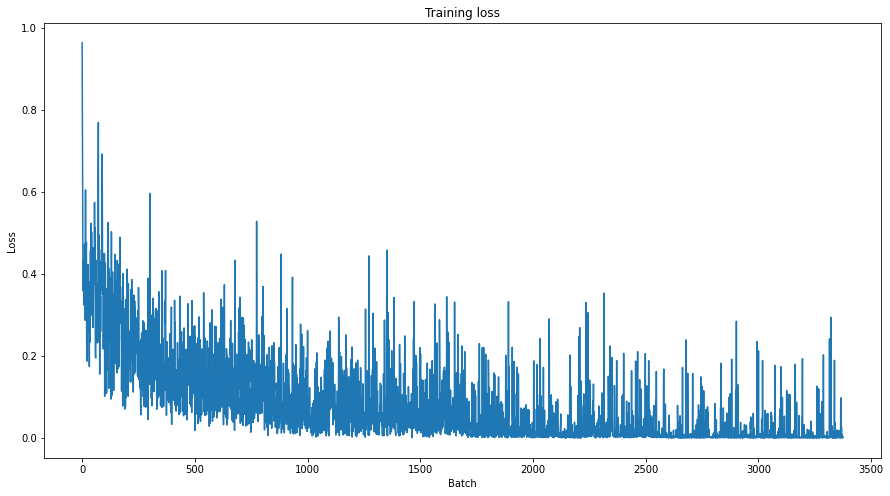

In [ ]:
# Training Evaluation
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

We can observe a clear downward trend for training loss.

In [ ]:
# Saving the model

torch.save(model, 'my_model')

-------------